# Readseeker Evaluation Notebook

by Ben Wulf @ HTW Berlin - University of Applied Sciences

## Import Dependencies

In [1]:
import pandas
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import gzip
import os

from sklearn.metrics import confusion_matrix


## Load Readseeker Data

In [2]:
readseeker_result_filename = "benchmark_result/dnabertCDS_classification_benchmark_11Samples_6References.tsv"
readseeker_result = pandas.read_csv(readseeker_result_filename,sep ="\t",lineterminator='\n')

# HotFix for LTS and Language Issues
readseeker_result.rename(columns={"Referenz": "Reference"},inplace=True)
if "ReadNotInBlastHits" in readseeker_result:
    readseeker_result.drop(['ReadNotInBlastHits'], axis=1,inplace=True)

## Rename references to scientific names

In [3]:
renameSamples = {
    "ecoli":"Escherichia coli",
    "human":"Human",
    "gammaherpes4":"Epstein-Barr Virus",
    "sars2":"SARS-CoV-2",
    "mycobacteriumtubercolosis":"Mycobacterium tuberculosis",
    "mouse": "Mus musculus"
}

readseeker_result = readseeker_result.loc[:("Reference")].replace(renameSamples)


## Caluclate Values for ROC -Curves

In [4]:
def df2rocdf(df,reference,sample):
    metasamplename = ' / '.join([reference,sample])
    label, prediction = df["Label"],df["Prediction"]

    fpr,tpr, p = metrics.roc_curve(label,prediction,pos_label=1)
    return pd.DataFrame({"False Positive Rate":fpr, "Recall":tpr, "Points":p,"Reference":reference,"Sample":sample})

                

roc_temp = []

# Sort samples for Plot with dict order
order = {"SARS-CoV-2":"SARS-CoV-2"}

for e in readseeker_result["Reference"].unique():
    order[e]=e

for reference in order:

    reference_subset = readseeker_result.loc[readseeker_result["Reference"]==reference,:]
    samples = reference_subset["Sample"].unique()
    
    for sample in samples:

        samplesubset = reference_subset.loc[reference_subset["Sample"]==sample,:]
        roc_temp.append(df2rocdf(samplesubset,reference,sample))
        
    if len(samples) >1:
        roc_temp.append(df2rocdf(reference_subset,reference,"Average"))

ROC_plotdata = pd.concat(roc_temp)


# Assign labels to classification results

This function will assign the labels True Positive, True Negative,False Negative and False Positive to the reads. 0.5 is used as prediction cuttoff to distiguish between positive and negative prediction results.


In [5]:
decions = readseeker_result.copy()
decions["BinaryDecision"] = "coding"
decions.loc[decions.loc[:,"Prediction"]<0.5,"BinaryDecision"] = "noncoding"
decions["Class"] = "None"
decions.loc[(decions.loc[:,"Prediction"]>=0.5)&(decions.loc[:,"Label"]==1),"Class"] = "True Positive"
decions.loc[(decions.loc[:,"Prediction"]<0.5)&(decions.loc[:,"Label"]==0),"Class"] = "True Negative"
decions.loc[(decions.loc[:,"Prediction"]>=0.5)&(decions.loc[:,"Label"]==0),"Class"] = "False Positive"
decions.loc[(decions.loc[:,"Prediction"]<0.5)&(decions.loc[:,"Label"]==1),"Class"] = "False Negative"

# Convert to Countdata
decisions3=decions.groupby(['Reference',"Class"]).size().reset_index().pivot(columns='Class', index='Reference', values=0).fillna(0).reindex(["False Negative","False Positive","True Negative","True Positive",],axis=1)
display(decisions3)

# Normalize to Percent
decisions4 = decisions3.div(decisions3.agg(sum,axis=1)/100,axis="rows")
decisions4["Accuracy"] = (decisions3["True Positive"]+decisions3["True Negative"])/(decisions3["True Positive"]+decisions3["True Negative"]+(decisions3["False Positive"]+decisions3["False Negative"]))
display(decisions4)

Class,False Negative,False Positive,True Negative,True Positive
Reference,,,,
Epstein-Barr Virus,27471.0,18666.0,369588.0,360783.0
Escherichia coli,225.0,515.0,7797.0,8087.0
Human,1644.0,1239.0,42755.0,42350.0
Mus musculus,412.0,386.0,12577.0,12551.0
Mycobacterium tuberculosis,309.0,1357.0,14732.0,15780.0
SARS-CoV-2,70381.0,0.0,8.0,669413.0


Class,False Negative,False Positive,True Negative,True Positive,Accuracy
Reference,,,,,
Epstein-Barr Virus,3.537761,2.403839,47.596161,46.462239,0.940584
Escherichia coli,1.353465,3.097931,46.902069,48.646535,0.955486
Human,1.868437,1.408147,48.591853,48.131563,0.967234
Mus musculus,1.589138,1.488853,48.511147,48.410862,0.969220
Mycobacterium tuberculosis,0.960283,4.217167,45.782833,49.039717,0.948225
SARS-CoV-2,9.513491,0.000000,0.001081,90.485427,0.904865


## Ploting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


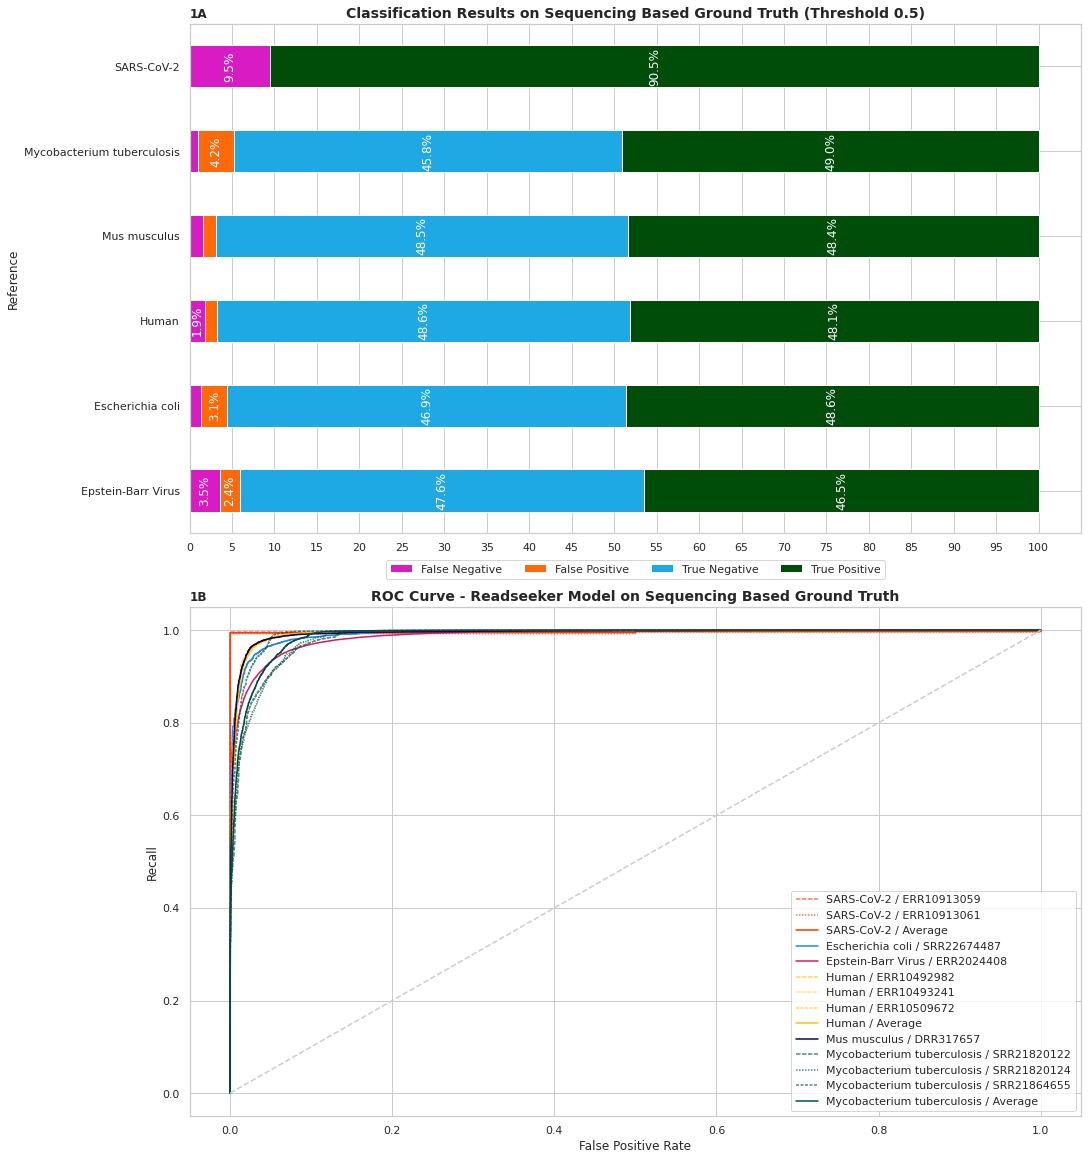

In [6]:
%matplotlib inline

sns.set(rc={'figure.figsize':(15,16)})
sns.set_style("whitegrid")

fig, axes = plt.subplot_mosaic([['1A'], ['1B']],layout='constrained')


## Result Barplot  2A




p=decisions4[["False Negative","False Positive","True Negative","True Positive"]].plot(kind='barh', stacked=True, ylabel='Percentage', xlabel='Reference',ax=axes["1A"],
                        color={'False Negative':'#D81BC3',
                       'False Positive':'#FF6907',
                       'True Negative':"#1EA9E5",
                       'True Positive':"#004D0A"}
            )
p.set_title('Classification Results on Sequencing Based Ground Truth (Threshold 0.5)',fontdict={'size': 14, 'weight': 'bold'})
    #p.tick_params(axis='x', rotation=20,labelright=True)
p.set_xticks(range(0,101,5))
p.legend(title='', loc='lower center',bbox_to_anchor=(0.5, -0.1),ncol =4)
threshold = 1.6
for c in p.containers:
    # Filter the labels
    labels = ["%.1f%%"%v if v > threshold else "" for v in c.datavalues]    
    p.bar_label(c, labels=labels, label_type="center", color = "white", rotation=90)








## ROC PLOT  2B

ROC_plotdata =ROC_plotdata.assign(Metasample = ROC_plotdata[["Reference","Sample"]].agg(' / '.join, axis=1))
colors = ["#FF3400","#1E88E5","#D81B60","#FFC107","#0d004d","#004D40"]

noAVG = {'Escherichia coli / SRR22674487', 'Epstein-Barr Virus / ERR2024408','Mus musculus / DRR317657'}

colperREF = {x:y for x,y in zip(ROC_plotdata.loc[:,"Reference"].unique(),colors)}


metapal = {x:colperREF["/".join(x.split(" / ")[:-1])]+("" if x.endswith("Average") or x in noAVG else "AA") for x in ROC_plotdata.loc[:,"Metasample"].unique()}






metadash = {x+" / "+y: ["",(3,1),(1,1),(2,1)][int(y != "Average" and ((x+" / "+y) not in noAVG))*(i+1)]
                 for x in ROC_plotdata.loc[:,"Reference"].unique() for i,y in enumerate(list( ROC_plotdata.loc[ROC_plotdata.loc[:,"Reference"]==x,"Sample"].unique()))}

roc_plot = sns.lineplot(ax=axes["1B"],data=ROC_plotdata,y="Recall",x="False Positive Rate",hue = "Metasample",style="Metasample",estimator=None,dashes=metadash,palette=metapal)

roc_plot.set_title("ROC Curve - Readseeker Model on Sequencing Based Ground Truth", fontdict={'size': 14, 'weight': 'bold'})
roc_plot.legend().set_title(None)
sns.lineplot(ax= axes["1B"],x=[0,1],y=[0,1],color=(0.8,0.8,0.8),linestyle="--",estimator=None)

# Set Subfigure Labels
for label,ax in axes.items():
    ax.set_title(label,fontdict={'size': 16, 'weight': 'bold'}, loc='left', fontsize='medium')

os.makedirs("plots", exist_ok=True)
fig.savefig("plots/roc_plot.svg", format='svg')
fig.savefig("plots/roc_plot.eps", format="eps")
plt.show()



##  Load FragGeneScan Data

In [7]:
fraggene_result_filename = "benchmark_result/fraggene_classification_benchmark_11Samples_6References.tsv"
fraggene_result = pandas.read_csv(fraggene_result_filename,sep ="\t",lineterminator='\n')


# Rename reference sequences as above 
fraggene_result = fraggene_result.loc[:("Reference")].replace(renameSamples)

# Calculate Metrics

In [8]:
coefr  = readseeker_result.copy()
coefr["PredictedLabel"] = 0
coefr.loc[coefr.loc[:,"Prediction"]>=0.5,"PredictedLabel"] =1

def metricsSubset(subset):
    accuracy = metrics.accuracy_score(subset["Label"],subset["PredictedLabel"])
    fpr,tpr, _ = metrics.roc_curve(subset["Label"],subset["Prediction"],pos_label=1)
    roc_auc = metrics.auc(fpr,tpr)
    F1 = metrics.f1_score(subset["Label"],subset["PredictedLabel"])
    MCC = metrics.matthews_corrcoef(subset["Label"],subset["PredictedLabel"])
    x = pd.Series({"Accuracy":accuracy,"ROC-AUC":roc_auc,"F1":F1,"MCC":MCC})#

    return x


readseeker_performance= coefr.groupby("Reference").apply(metricsSubset).reset_index()
    
display(readseeker_performance)

    
    
    
    
    

,Reference,Accuracy,ROC-AUC,F1,MCC
0,Epstein-Barr Virus,0.940584,0.987394,0.939903,0.881395
1,Escherichia coli,0.955486,0.992511,0.956249,0.911527
2,Human,0.967234,0.994317,0.967083,0.934508
3,Mus musculus,0.969220,0.993639,0.969189,0.938442
4,Mycobacterium tuberculosis,0.948225,0.988371,0.949859,0.898359
5,SARS-CoV-2,0.904865,0.995816,0.950056,0.010141


### FragGeneScan

In [9]:
coefr_fgs  = fraggene_result.copy()

coefr_fgs["Prediction"]= coefr_fgs["fraction"]
#fraggenescan_performance = get_metrics(coefr_fgs)
fraggenescan_performance = coefr_fgs.groupby("Reference").apply(metricsSubset).reset_index()

display(fraggenescan_performance)

,Reference,Accuracy,ROC-AUC,F1,MCC
0,Epstein-Barr Virus,0.755186,0.870108,0.794221,0.551613
1,Escherichia coli,0.701155,0.809325,0.769552,0.499913
2,Human,0.705051,0.818510,0.755064,0.449271
3,Mus musculus,0.737406,0.865750,0.789773,0.547607
4,Mycobacterium tuberculosis,0.745509,0.839770,0.794602,0.559028
5,SARS-CoV-2,0.992209,0.990406,0.996089,-0.000291


### Join and Generate LaTeX

In [10]:
fraggenescan_performance["Tool"] = "FragGeneScan"
readseeker_performance["Tool"] = "Readseeker"

large_performance = pd.concat([readseeker_performance,fraggenescan_performance])


# sort references

sorder = {"Epstein-Barr Virus":0, "Escherichia coli":2, "Human":4, "SARS-CoV-2":1,
          "Mycobacterium tuberculosis":3,"Mus musculus":5}
large_performance["sorder"] = large_performance["Reference"].map(sorder)

large_performance.sort_values(by="sorder", inplace=True)
large_performance.drop(columns='sorder',inplace=True)



# Fit names for LaTeX Table
shortRefNames = {
    "Escherichia coli":"E. coli",
    "Mycobacterium tuberculosis":"M. tuberculosis",
    "Epstein-Barr Virus":"EBV"
    
}




large_performance["Reference"]= large_performance["Reference"].replace(shortRefNames)




large_performance.set_index(["Reference","Tool"],inplace=True)


# some style functions

def highlight_conditionally(val, number):

    if val >= number:
        return 'font-weight: bold'
    return ''

# Anwendung der Stilisierung mit MultiIndex-Betrachtung
def apply_highlight(x):

    
    max_in_reference = x.groupby(level='Reference').max()

    return [highlight_conditionally(z, max_in_reference[idx[0]]) for z,idx in zip(x, x.index)]

styled_df = large_performance.style.apply(apply_highlight, axis=0)
styled_df.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'midrule', 'props': ':hline;'},
#    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=True).format({"Accuracy": '{:.4f}',"ROC-AUC": '{:.4f}',"F1": '{:.4f}',"MCC": '{:.4f}'})
display(styled_df)

print(styled_df
      .format_index("\\textit{{{}}}", escape="latex", axis=0)
      .to_latex(clines="skip-last;data",caption="\\textbf{\\textit{ReadSeeker}-model and \\textit{FragGeneScan} benchmark metrics}",label="qualmeasurmentstable",column_format="|l|l|r|r|r|r|",convert_css=True)
      #.replace("\\\\\n\\m","\\\\\hline\n\\m")
      .replace("\\end{tabular}\n","\\end{tabular}\n\\input{Tables/performance_table_desc}")
      .replace("\\begin{table}","\\begin{table}[!ht]"))



\begin{table}[!ht]
\caption{\textbf{\textit{ReadSeeker}-model and \textit{FragGeneScan} benchmark metrics}}
\label{qualmeasurmentstable}
\begin{tabular}{|l|l|r|r|r|r|}
\hline
 &  & Accuracy & ROC-AUC & F1 & MCC \\
Reference & Tool &  &  &  &  \\
\hline
\multirow[c]{2}{*}{\textit{EBV}} & \textit{Readseeker} & \bfseries 0.9406 & \bfseries 0.9874 & \bfseries 0.9399 & \bfseries 0.8814 \\
 & \textit{FragGeneScan} & 0.7552 & 0.8701 & 0.7942 & 0.5516 \\
\cline{1-6}
\multirow[c]{2}{*}{\textit{SARS-CoV-2}} & \textit{Readseeker} & 0.9049 & \bfseries 0.9958 & 0.9501 & \bfseries 0.0101 \\
 & \textit{FragGeneScan} & \bfseries 0.9922 & 0.9904 & \bfseries 0.9961 & -0.0003 \\
\cline{1-6}
\multirow[c]{2}{*}{\textit{E. coli}} & \textit{Readseeker} & \bfseries 0.9555 & \bfseries 0.9925 & \bfseries 0.9562 & \bfseries 0.9115 \\
 & \textit{FragGeneScan} & 0.7012 & 0.8093 & 0.7696 & 0.4999 \\
\cline{1-6}
\multirow[c]{2}{*}{\textit{M. tuberculosis}} & \textit{Readseeker} & \bfseries 0.9482 & \bfseries 0.9884 

#  Suplemental confusion matrices
## Readseeker

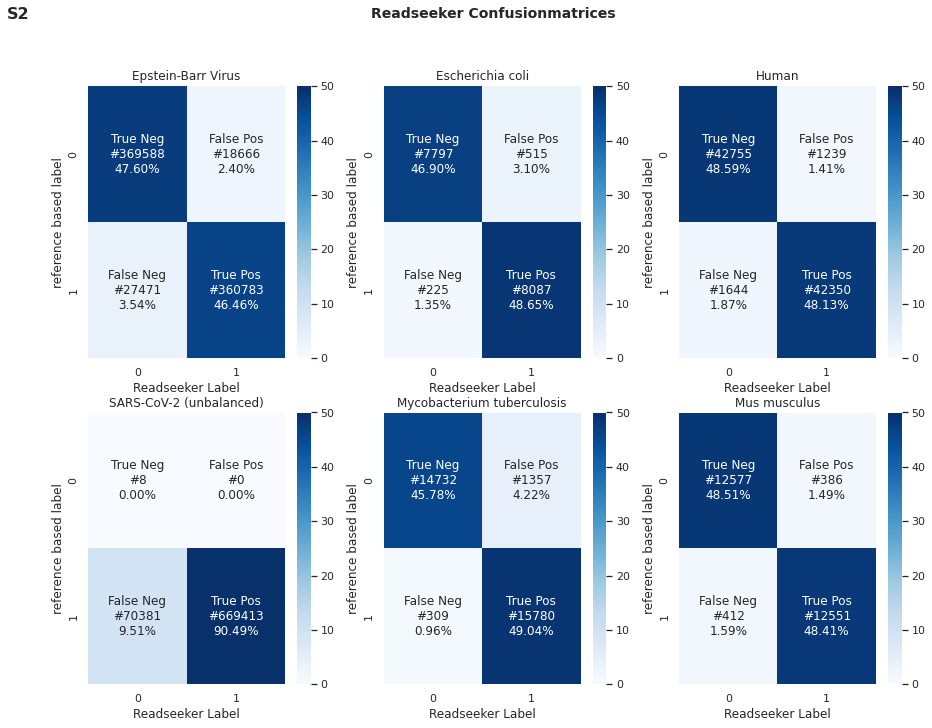

In [11]:
# confusion plot order

porder = {"Epstein-Barr Virus":(0,0), "Escherichia coli":(0,1), "Human":(0,2), "SARS-CoV-2":(1,0),
          "Mycobacterium tuberculosis":(1,1),"Mus musculus":(1,2)}

def plot_confusionmatrix(dataorigin,result, porder,image_index):
    

    references = set(result["Reference"])
    matrices = dict()

    fig, axes = plt.subplots(2, len(references)//2, sharex=False, figsize=(15,11))
    fig.text(0.05, 0.98, image_index, fontsize=16, fontweight='bold', ha='left', va='top')
    #axes[0][0].set_title("S1",fontdict={'size': 16, 'weight': 'bold'}, loc='left', fontsize='medium')
    
    fig.suptitle(f"{dataorigin} Confusionmatrices",size= 14, weight= 'bold')

    #fig.suptitle(f"{dataorigin} Confusionmatrices",fontdict={'size': 14, 'weight': 'bold'})

    for ref in references: 
        subset = result.loc[result["Reference"]==ref,:]

        ## Adapted from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
        cf_matrix = confusion_matrix( subset["Label"],subset["PredictedLabel"])

        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["#{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)


        sns.heatmap(cf_matrix/np.sum(cf_matrix)*100,ax= axes[porder[ref][0]][porder[ref][1]], annot=labels, 
               fmt='', cmap='Blues',vmin=0, vmax=50)

        axes[porder[ref][0]][porder[ref][1]].set(ylabel='reference based label', xlabel=f'{dataorigin} Label',title=(ref+" (unbalanced)" if ref=="SARS-CoV-2" else ref))

    return (fig,axes)

f, a = plot_confusionmatrix("Readseeker", coefr,porder,image_index="S2")

f.savefig("plots/Readseeker_confusion.eps", format="eps")
f.savefig("plots/Readseeker_confusion.svg", format="svg")



## FragGeneScan

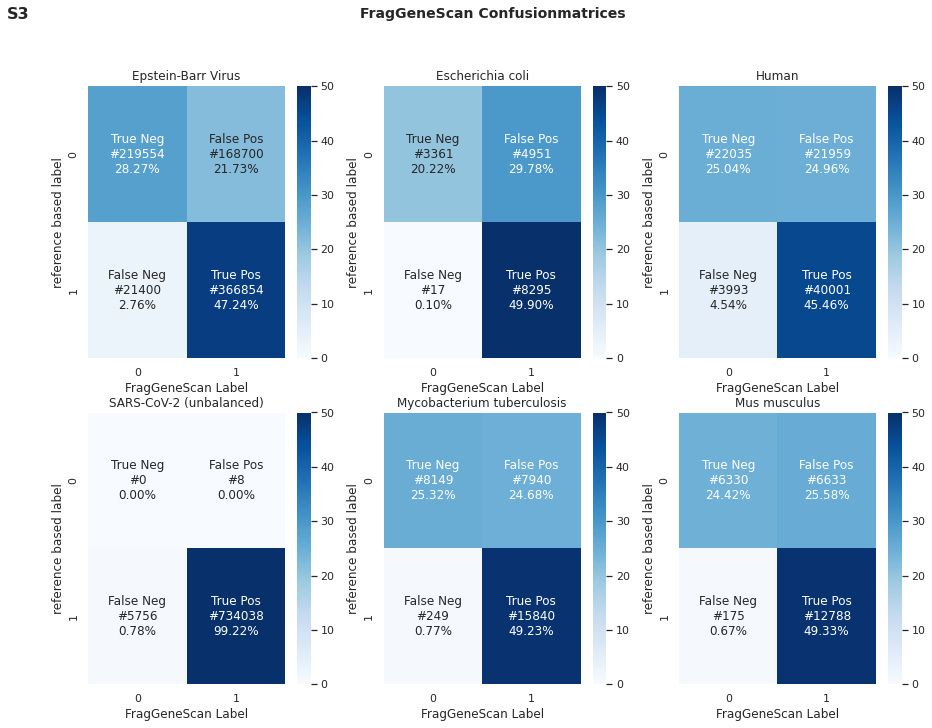

In [12]:
f, a = plot_confusionmatrix("FragGeneScan", coefr_fgs,porder,image_index="S3")
f.savefig("plots/FragGeneScan_confusion.eps", format="eps")
f.savefig("plots/FragGeneScan_confusion.svg", format="svg")



## Generate Read Statisics

In [13]:
filtered_reads={(sample,reference):[f"benchmark/{reference}/{sample}/{sample}_reads.fasta"] for reference, sample in [('human','ERR10493241'),
                                                                                             ('human','ERR10492982'),
                                                                                             ('human','ERR10509672'),
                                                                                             ('sars2','ERR10913059'),
                                                                                             ('sars2','ERR10913061'),
                                                                                             ('ecoli','SRR22674487'),
                                                                                             ('mycobacteriumtubercolosis','SRR21820122'),
                                                                                             ('mycobacteriumtubercolosis','SRR21864655'),
                                                                                             ('mycobacteriumtubercolosis','SRR21820124'),
                                                                                             ('gammaherpes4','ERR2024408'),
                                                                                             ('mouse','DRR317657')]}


In [14]:
rliste = []

unknowns = set()
for (sample,reference) ,l in filtered_reads.items():
    readl=[]
    ncount = 0
    nreadswithns = 0
    readcount = 0
    for e in l:
    
        with open(e,"r") as f:
            f.readline()
            seq = f.readline()
            while seq:
                sseq = seq.strip().upper()
            
                readl.append(len(sseq))
                unknown = [base for base in sseq if base not in {"A","C","G","T"}]
                readcount += 1
                if unknown:
                    unknowns.update(set(unknown))
                    ncount +=len(unknown)
                    nreadswithns += 1
                
                
                f.readline()
                seq = f.readline()
    rliste.append({"Sample":sample,"Reference":reference ,"min_rl":min(readl),"max_rl":max(readl),"avg_rl":sum(readl)/len(readl),"N_count":ncount, "Reads_with_ns":nreadswithns, "Number_of_Reads":readcount,"Percent_Nreads":nreadswithns/readcount*100})

readcounts = pandas.DataFrame(data=rliste)
readcounts.set_index("Sample",inplace=True)
display(readcounts)

,Reference,min_rl,max_rl,avg_rl,N_count,Reads_with_ns,Number_of_Reads,Percent_Nreads
Sample,,,,,,,,
ERR10493241,human,251,251,251.000000,38,22,32084,0.068570
ERR10492982,human,251,251,251.000000,25,21,31642,0.066367
ERR10509672,human,251,251,251.000000,33,20,24262,0.082433
ERR10913059,sars2,140,301,252.216276,345,215,427828,0.050254
ERR10913061,sars2,140,301,258.031592,177,115,311974,0.036862
SRR22674487,ecoli,151,151,151.000000,245,239,16624,1.437680
SRR21820122,mycobacteriumtubercolosis,301,301,301.000000,0,0,9718,0.000000
SRR21864655,mycobacteriumtubercolosis,301,301,301.000000,0,0,12576,0.000000
SRR21820124,mycobacteriumtubercolosis,301,301,301.000000,0,0,9884,0.000000


In [15]:
read_count_base_data = pd.DataFrame([["mammal" , "human (GRCh38)" , "ERR10492982" , "-",   "balanced" ],
["mammal" , "human (GRCh38)" , "ERR10493241" , "-",   "balanced"  ],
["mammal" , "human (GRCh38)" , "ERR10509672" , "-",   "balanced" ],
["mammal" , "Mus Musculus (NC_000067.7)" , "DRR317657" , "-",   "balanced" ],
["bacterial" , "M.tuberculosis (NC_000962.3)",  "SRR21820122" , "1762" , "balanced" ],
["bacterial" , "M.tuberculosis (NC_000962.3)",  "SRR21820124" , "1762" , "balanced"],
["bacterial" , "M.tuberculosis (NC_000962.3)",  "SRR21864655" , "1762" , "balanced"],
["bacterial" , "E.Coli (NC_000913.3)", "SRR22674487" , "561" , "balanced" , ],
["viral" , "EBV (GCF_002402265)" , "ERR2024408" , "548681" , "balanced" ],
["viral" , "SARS-CoV-2 (NC_045512.2)" , "ERR10913059" , "-",   "unbalanced" ],
["viral" , "SARS-CoV-2 (NC_045512.2) " , "ERR10913061" , "-",   "unbalanced" ]],
                                    columns =["Reference Category", "Reference", "SRA SampleID", "Uniprot Taxon", "cds balancing"])

read_count_base_data["# Reads"] = read_count_base_data["SRA SampleID"].map(readcounts["Number_of_Reads"])
read_count_base_data["Read length"] = read_count_base_data["SRA SampleID"].map(readcounts["max_rl"])


read_count_base_data.reset_index(drop=True, inplace=True)

read_count_base_data_styled = read_count_base_data.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'midrule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=True).hide(axis='index')
display(read_count_base_data_styled)






Reference Category,Reference,SRA SampleID,Uniprot Taxon,cds balancing,# Reads,Read length
mammal,human (GRCh38),ERR10492982,-,balanced,31642,251
mammal,human (GRCh38),ERR10493241,-,balanced,32084,251
mammal,human (GRCh38),ERR10509672,-,balanced,24262,251
mammal,Mus Musculus (NC_000067.7),DRR317657,-,balanced,25926,255
bacterial,M.tuberculosis (NC_000962.3),SRR21820122,1762,balanced,9718,301
bacterial,M.tuberculosis (NC_000962.3),SRR21820124,1762,balanced,9884,301
bacterial,M.tuberculosis (NC_000962.3),SRR21864655,1762,balanced,12576,301
bacterial,E.Coli (NC_000913.3),SRR22674487,561,balanced,16624,151
viral,EBV (GCF_002402265),ERR2024408,548681,balanced,776508,300
viral,SARS-CoV-2 (NC_045512.2),ERR10913059,-,unbalanced,427828,301


## Read Statistics LaTeX

In [16]:
print(read_count_base_data_styled.to_latex(caption="\\textbf{Overview Test Dataset}",label="sampletable",column_format="|p{0.8in}|l|l|p{0.45in}|l|l|p{0.35in}|",convert_css=True).replace("\\\\\n\\m","\\\\\hline\n\\m").replace("\\end{tabular}\n","\\end{tabular}\n\\input{Tables/sampletable_table_desc}").replace("\\begin{table}","\\begin{table}[!ht]").replace("_","\\_").replace("#","\\#"))


\begin{table}[!ht]
\caption{\textbf{Overview Test Dataset}}
\label{sampletable}
\begin{tabular}{|p{0.8in}|l|l|p{0.45in}|l|l|p{0.35in}|}
\hline
Reference Category & Reference & SRA SampleID & Uniprot Taxon & cds balancing & \# Reads & Read length \\
\hline
mammal & human (GRCh38) & ERR10492982 & - & balanced & 31642 & 251 \\
mammal & human (GRCh38) & ERR10493241 & - & balanced & 32084 & 251 \\
mammal & human (GRCh38) & ERR10509672 & - & balanced & 24262 & 251 \\
mammal & Mus Musculus (NC\_000067.7) & DRR317657 & - & balanced & 25926 & 255 \\
bacterial & M.tuberculosis (NC\_000962.3) & SRR21820122 & 1762 & balanced & 9718 & 301 \\
bacterial & M.tuberculosis (NC\_000962.3) & SRR21820124 & 1762 & balanced & 9884 & 301 \\
bacterial & M.tuberculosis (NC\_000962.3) & SRR21864655 & 1762 & balanced & 12576 & 301 \\
bacterial & E.Coli (NC\_000913.3) & SRR22674487 & 561 & balanced & 16624 & 151 \\
viral & EBV (GCF\_002402265) & ERR2024408 & 548681 & balanced & 776508 & 300 \\
viral & SARS-CoV-2 (

# Runtime Evaluation

In [17]:
times = pd.read_csv("benchmark_result/classification_timingresults_11Samples_6References.tsv")
times=times.sort_values(by=["Reference","Sample","Tool"])

display(times)


#Optimize Format

caption_runtime = "Real process time comparison of \\textit{Readseeker} and \\textit{FragGeneScan}"
times_real = times[["Reference","Sample","Tool","Real"]].copy()



# Fit names for LaTeX Table
shortRefNames = {
    "ecoli":"E. coli",
    "mycobacteriumtubercolosis":"M. tuberculosis",
    "gammaherpes4":"EBV",
    "sars2":"SARS-CoV-2",
    "human":"Human",
    "mouse":"Mouse",
    
    
}

times_real["Reference"].replace(shortRefNames,inplace=True)


times_real_wide = times_real.pivot(index=["Reference","Sample"],columns='Tool', values='Real')
times_real_wide["speed factor"] = times_real_wide["Readseeker"]/times_real_wide["FragGeneScan"]



times_real_wide_styled = times_real_wide.style.format({"speed factor": '{:.1f}x',"Readseeker": '{:.1f}s',"FragGeneScan": '{:.1f}s'})








print("Table for Paper")
display(times_real_wide_styled)




description = """
The values in the ``FragGeneScan'' and ``Readseeker'' column represents the real process time
in seconds. Speed Factor is the relative runtime of both. On average \\textit{Readseeker} is
around 25 times slower on a \\textit{NVIDIA A40-24Q} with 24GB memory compared to 
\\textit{FragGeneScan} on \textit{Intel(R) Xeon(R) Gold 6130} with CPU cores.
"""

,Tool,Sample,Reference,User,System,Real
11,FragGeneScan,SRR22674487,ecoli,7.09,26.73,3.79
0,Readseeker,SRR22674487,ecoli,118.44,4.84,96.89
12,FragGeneScan,ERR2024408,gammaherpes4,410.70,1398.58,148.78
1,Readseeker,ERR2024408,gammaherpes4,3439.63,18.71,3461.21
13,FragGeneScan,ERR10492982,human,16.04,56.10,6.72
2,Readseeker,ERR10492982,human,241.19,5.25,171.47
14,FragGeneScan,ERR10493241,human,16.22,53.38,6.81
3,Readseeker,ERR10493241,human,243.82,5.56,173.31
15,FragGeneScan,ERR10509672,human,12.67,42.61,5.37
4,Readseeker,ERR10509672,human,187.50,5.16,135.09


Table for Paper


### Runtime Performance LaTeX

In [18]:
print(times_real_wide_styled
      .format_index("\\textit{{{}}}", escape="latex", axis=0)
      .set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'midrule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},], overwrite=True)
      .to_latex(clines="skip-last;data",label="readseeker_runtime", column_format="|l|l|r|r|r|", caption=caption_runtime)
      .replace("\end{tabular}\n","\end{tabular}\n"+description)
      .replace("\\begin{table}","\\begin{table}[!ht]"))

\begin{table}[!ht]
\caption{Real process time comparison of \textit{Readseeker} and \textit{FragGeneScan}}
\label{readseeker_runtime}
\begin{tabular}{|l|l|r|r|r|}
\hline
 & Tool & FragGeneScan & Readseeker & speed factor \\
Reference & Sample &  &  &  \\
\hline
\textit{E. coli} & \textit{SRR22674487} & 3.8s & 96.9s & 25.6x \\
\cline{1-5}
\textit{EBV} & \textit{ERR2024408} & 148.8s & 3461.2s & 23.3x \\
\cline{1-5}
\multirow[c]{3}{*}{\textit{Human}} & \textit{ERR10492982} & 6.7s & 171.5s & 25.5x \\
 & \textit{ERR10493241} & 6.8s & 173.3s & 25.4x \\
 & \textit{ERR10509672} & 5.4s & 135.1s & 25.2x \\
\cline{1-5}
\multirow[c]{3}{*}{\textit{M. tuberculosis}} & \textit{SRR21820122} & 2.6s & 67.0s & 26.1x \\
 & \textit{SRR21820124} & 2.7s & 69.2s & 25.8x \\
 & \textit{SRR21864655} & 3.1s & 79.8s & 25.8x \\
\cline{1-5}
\textit{Mouse} & \textit{DRR317657} & 5.9s & 143.9s & 24.5x \\
\cline{1-5}
\multirow[c]{2}{*}{\textit{SARS-CoV-2}} & \textit{ERR10913059} & 86.0s & 2105.0s & 24.5x \\
 & \textit{

# Time per 1k samples

In [19]:
relative_times = times_real.copy()
display(relative_times)

counts = read_count_base_data[["SRA SampleID","# Reads"]].copy()
counts.set_index("SRA SampleID")

rpt = relative_times.merge(counts,left_on='Sample', right_on='SRA SampleID')
rpt["Seconds/1000 Reads"] = rpt["Real"]/rpt["# Reads"]*1000

display(rpt)


rpt_wide=rpt.pivot(index=["Reference","Sample","# Reads"],columns='Tool', values='Seconds/1000 Reads')
rpt_wide_styled = rpt_wide.style.format({"Readseeker": '{:.2f}s',"FragGeneScan": '{:.2f}s'}).set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'midrule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},], overwrite=True)
display(rpt_wide_styled)

description = """The table presents a comparison of the real processing time required by \\textit{Readseeker} and \\textit{FragGeneScan}. The column labeled `\\# Reads' indicates the number of reads for each sample. The columns for \\textit{FragGeneScan} and \\textit{Readseeker} display the real processing time measured per 1,000 reads."""

print(rpt_wide_styled.to_latex(column_format="|l|l|l|r|r|",clines="skip-last;data",label="subtab_processtime1k", caption="Comparison of the Real Processing Time per 1000 Reads").replace("#","\\#").replace("\end{tabular}\n","\end{tabular}\n"+description))


,Reference,Sample,Tool,Real
11,E. coli,SRR22674487,FragGeneScan,3.79
0,E. coli,SRR22674487,Readseeker,96.89
12,EBV,ERR2024408,FragGeneScan,148.78
1,EBV,ERR2024408,Readseeker,3461.21
13,Human,ERR10492982,FragGeneScan,6.72
2,Human,ERR10492982,Readseeker,171.47
14,Human,ERR10493241,FragGeneScan,6.81
3,Human,ERR10493241,Readseeker,173.31
15,Human,ERR10509672,FragGeneScan,5.37
4,Human,ERR10509672,Readseeker,135.09


,Reference,Sample,Tool,Real,SRA SampleID,# Reads,Seconds/1000 Reads
0,E. coli,SRR22674487,FragGeneScan,3.79,SRR22674487,16624,0.227984
1,E. coli,SRR22674487,Readseeker,96.89,SRR22674487,16624,5.828321
2,EBV,ERR2024408,FragGeneScan,148.78,ERR2024408,776508,0.191601
3,EBV,ERR2024408,Readseeker,3461.21,ERR2024408,776508,4.457404
4,Human,ERR10492982,FragGeneScan,6.72,ERR10492982,31642,0.212376
5,Human,ERR10492982,Readseeker,171.47,ERR10492982,31642,5.419063
6,Human,ERR10493241,FragGeneScan,6.81,ERR10493241,32084,0.212255
7,Human,ERR10493241,Readseeker,173.31,ERR10493241,32084,5.401758
8,Human,ERR10509672,FragGeneScan,5.37,ERR10509672,24262,0.221334
9,Human,ERR10509672,Readseeker,135.09,ERR10509672,24262,5.567966


\begin{table}
\caption{Comparison of the Real Processing Time per 1000 Reads}
\label{subtab_processtime1k}
\begin{tabular}{|l|l|l|r|r|}
\hline
 &  & Tool & FragGeneScan & Readseeker \\
Reference & Sample & \# Reads &  &  \\
\hline
E. coli & SRR22674487 & 16624 & 0.23s & 5.83s \\
\cline{1-5} \cline{2-5}
EBV & ERR2024408 & 776508 & 0.19s & 4.46s \\
\cline{1-5} \cline{2-5}
\multirow[c]{3}{*}{Human} & ERR10492982 & 31642 & 0.21s & 5.42s \\
\cline{2-5}
 & ERR10493241 & 32084 & 0.21s & 5.40s \\
\cline{2-5}
 & ERR10509672 & 24262 & 0.22s & 5.57s \\
\cline{1-5} \cline{2-5}
\multirow[c]{3}{*}{M. tuberculosis} & SRR21820122 & 9718 & 0.26s & 6.90s \\
\cline{2-5}
 & SRR21820124 & 9884 & 0.27s & 7.01s \\
\cline{2-5}
 & SRR21864655 & 12576 & 0.25s & 6.35s \\
\cline{1-5} \cline{2-5}
Mouse & DRR317657 & 25926 & 0.23s & 5.55s \\
\cline{1-5} \cline{2-5}
\multirow[c]{2}{*}{SARS-CoV-2} & ERR10913059 & 427828 & 0.20s & 4.92s \\
\cline{2-5}
 & ERR10913061 & 311974 & 0.20s & 4.91s \\
\cline{1-5} \cline{2-5}
